In [41]:
import pandas as pd

# Load the dataset
file_path = '/mnt/data/dv3.csv'
data = pd.read_csv(file_path)

# Calculate the rate of HbA1c reduction over time
data['HbA1c_reduction_rate_1_2'] = (data['HbA1c1'] - data['HbA1c2']) / data['Gap from initial visit (days)']
data['HbA1c_reduction_rate_2_3'] = (data['HbA1c2'] - data['HbA1c3']) / data['Gap from initial visit (days)']

# Combine Visit Intervals and Trends
data['visit_trend'] = data['Gap from initial visit (days)'] * data['Visit_Interval_Ratio']

# Optionally, save the updated dataset
data.to_csv('/mnt/data/updated_dv3.csv', index=False)

print(data.head())


   AGE  GENDER  DURATION DM INSULIN REGIMEN  DDS1  FVG1  HbA1c1      Date1  \
0   42  FEMALE           15             PBD  2.59   7.9     9.1  9/10/2020   
1   40    MALE            8              BB  3.35   5.1     9.3  10/8/2020   
2   28    MALE            7             PBD  2.76  21.5    12.1  8/25/2020   
3   32    MALE           13             PBD  2.59   9.1     8.3  8/26/2020   
4   49  FEMALE           18              BB  1.41  15.3     9.4  9/10/2020   

   Gap from initial visit (days)  FVG2  ...  eGFR_stage_code  \
0                             91  10.1  ...                1   
1                             98   3.0  ...                1   
2                             84   6.6  ...                1   
3                             83   7.8  ...                4   
4                             91  12.6  ...                1   

                eGFR_stage_label Visit_Interval_Ratio  ReductionA_per_day  \
0          Stage 1 - Normal/High             0.473988            0.11

In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load dataset
file_path = '/mnt/data/updated_dv3.csv'
data = pd.read_csv(file_path)

# Preprocess the 'Date1' column to convert it to datetime format
data['Date1'] = pd.to_datetime(data['Date1'], format='%m/%d/%Y')

# Extract days since the initial visit
data['Days_since_initial'] = (data['Date1'] - data['Date1'].min()).dt.days

# Calculate HbA1c change over time
data['HbA1c_change'] = data['HbA1c2'] - data['HbA1c1']

# Calculate the rate of HbA1c change over time
data['HbA1c_change_per_day'] = data['HbA1c_change'] / data['Days_since_initial']

# Handle infinite values: Replace them with a small threshold value
data['HbA1c_change_per_day'] = data['HbA1c_change_per_day'].replace([np.inf, -np.inf], 0.0001)

# Select features and target
features = ['AGE', 'DURATION DM', 'HbA1c1', 'Days_since_initial', 'HbA1c_change_per_day', 'GENDER']
target = 'HbA1c_change'

# Convert categorical variables to numerical values
data['GENDER'] = data['GENDER'].map({'MALE': 0, 'FEMALE': 1})

# Drop rows with missing target values
data_clean = data.dropna(subset=[target])

# Align the target variable y with the cleaned feature set X
X = data_clean[features]
y = data_clean[target]

# Ensure there are no infinite or NaN values
X = X.replace([np.inf, -np.inf], np.nan).dropna()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = linreg.predict(X_test)

# Evaluate the model
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

# Initialize and train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf.predict(X_test)

# Evaluate the model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# Initialize and train the XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

# Combine and display model performance
model_performance = {
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'MAE': [mae_lr, mae_rf, mae_xgb],
    'RMSE': [rmse_lr, rmse_rf, rmse_xgb]
}

# Convert the dictionary to a DataFrame
performance_df = pd.DataFrame(model_performance)

# Display the comparison table
performance_df = performance_df.sort_values(by='RMSE', ascending=True)  # You can change sorting criterion
performance_df


,Model,MAE,RMSE
2,XGBoost,0.294891,0.396066
1,Random Forest,0.335571,0.426850
0,Linear Regression,0.581009,0.718557


Mean Absolute Error (MAE): 0.2948911441223964
Root Mean Squared Error (RMSE): 0.39606577260838444


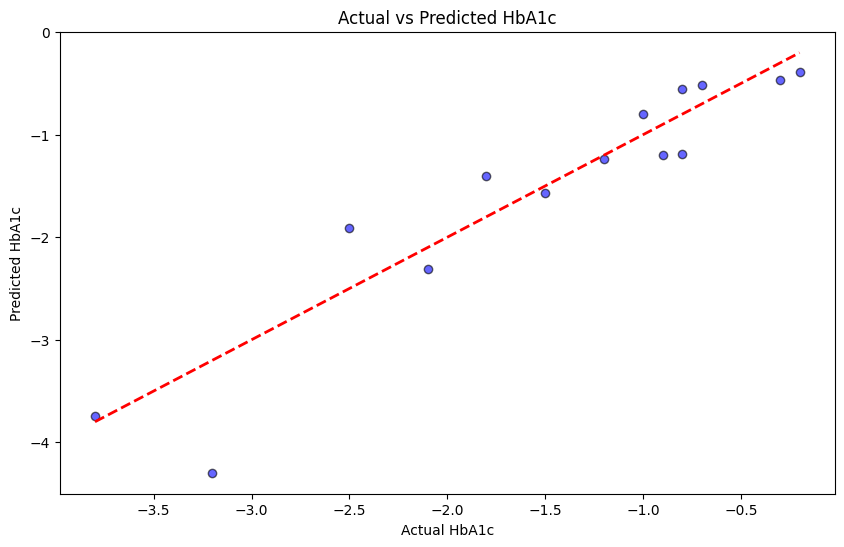

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load dataset
file_path = '/mnt/data/updated_dv3.csv'
data = pd.read_csv(file_path)

# Preprocess the 'Date1' and 'Date2' columns to convert them to datetime format
data['Date1'] = pd.to_datetime(data['Date1'], format='%m/%d/%Y', errors='coerce')
data['Date2'] = pd.to_datetime(data['Date2'], format='%m/%d/%Y', errors='coerce')

# Calculate the gap in days for each of the relevant periods
data['Gap_from_initial_visit'] = (data['Date1'] - data['Date1'].min()).dt.days
data['Gap_from_first_clinical_visit'] = (data['Date2'] - data['Date1']).dt.days

# Calculate HbA1c change over time
data['HbA1c_change'] = data['HbA1c2'] - data['HbA1c1']

# Calculate the rate of HbA1c change over time
data['HbA1c_change_per_day'] = data['HbA1c_change'] / data['Gap_from_initial_visit']

# Handle infinite values: Replace them with a small threshold value
data['HbA1c_change_per_day'] = data['HbA1c_change_per_day'].replace([np.inf, -np.inf], 0.0001)

# Select features and target
features = ['AGE', 'DURATION DM', 'HbA1c1', 'Gap_from_initial_visit', 'HbA1c_change_per_day', 'GENDER']
target = 'HbA1c_change'

# Convert categorical variables to numerical values
data['GENDER'] = data['GENDER'].map({'MALE': 0, 'FEMALE': 1})

# Drop rows with missing target values
data_clean = data.dropna(subset=[target])

# Align the target variable y with the cleaned feature set X
X = data_clean[features]
y = data_clean[target]

# Ensure there are no infinite or NaN values
X = X.replace([np.inf, -np.inf], np.nan).dropna()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost Regression model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model's performance
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

# Output the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae_xgb}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb}")

# Plot the actual vs predicted HbA1c values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, color='blue', alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual HbA1c')
plt.ylabel('Predicted HbA1c')
plt.title('Actual vs Predicted HbA1c')
plt.show()


Predicted HbA1c after Follow-up 1: -1.331994652748108
Predicted HbA1c after Follow-up 2: -1.0719438791275024
HbA1c reduction after Follow-up 1: 9.83%
HbA1c reduction after Follow-up 2: 9.87%


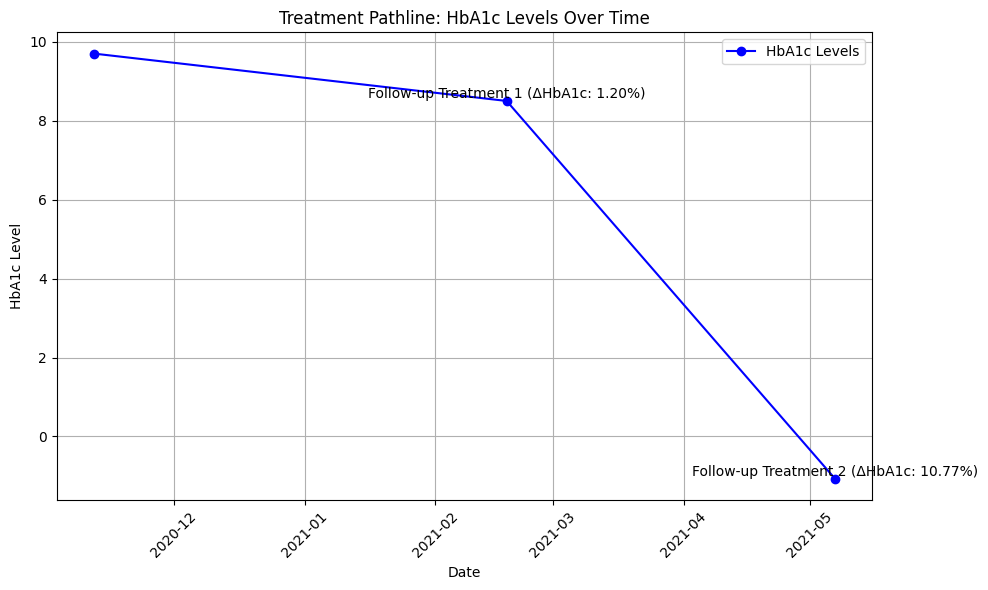

Text(0.5, -0.15, 'Initial Treatment - Date: 11/12/2020, HbA1c: 9.7, Gap: 98 days\nFollow-up Treatment 1 - Date: 02/18/2021, HbA1c: 8.5, Gap: 98 days\nFollow-up Treatment 2 - Date: 05/07/2021, HbA1c: -1.0719438791275024, Gap: 78 days')

<Figure size 640x480 with 0 Axes>

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load dataset
file_path = '/mnt/data/updated_dv3.csv'
data = pd.read_csv(file_path)

# Ensure 'Date1' and 'Date2' columns are datetime format
data['Date1'] = pd.to_datetime(data['Date1'], format='%m/%d/%Y', errors='coerce')
data['Date2'] = pd.to_datetime(data['Date2'], format='%m/%d/%Y', errors='coerce')

# Ensure the 'GENDER' column is converted to numerical values
data['GENDER'] = data['GENDER'].map({'MALE': 0, 'FEMALE': 1})

# Select the patient data for evaluation
patient_data = data.iloc[27]

# Calculate Date0
date0 = patient_data['Date1'] - pd.Timedelta(days=patient_data['Gap from initial visit (days)'])

# Calculate Date2
date2 = patient_data['Date1'] + pd.Timedelta(days=patient_data['Gap from first clinical visit (days)'])

# Prepare features for prediction at different time milestones
patient_features_1 = patient_data[['AGE', 'DURATION DM', 'HbA1c1', 'Gap from initial visit (days)', 'HbA1c_per_day_change', 'GENDER']].values.reshape(1, -1)
patient_features_2 = patient_data[['AGE', 'DURATION DM', 'HbA1c1', 'Gap from first clinical visit (days)', 'HbA1c_per_day_change', 'GENDER']].values.reshape(1, -1)

# Ensure that all features are numeric before prediction
patient_features_1 = patient_features_1.astype(np.float32)
patient_features_2 = patient_features_2.astype(np.float32)

# Predict the HbA1c value at Date1 and Date2
hba1c_day0_pred = patient_data['HbA1c1']  # Initial HbA1c
hba1c_follow_up_1_pred = xgb_model.predict(patient_features_1)[0]  # Predicted HbA1c after Follow-up 1
hba1c_follow_up_2_pred = xgb_model.predict(patient_features_2)[0]  # Predicted HbA1c after Follow-up 2

# Calculate HbA1c reduction
hba1c_reduction_follow_up_1 = patient_data['HbA1c2'] - hba1c_follow_up_1_pred  # Actual HbA1c at Follow-up 1
hba1c_reduction_follow_up_2 = patient_data['HbA1c3'] - hba1c_follow_up_2_pred  # Actual HbA1c at Follow-up 2

# Display the predicted HbA1c values and reduction
print(f"Predicted HbA1c after Follow-up 1: {hba1c_follow_up_1_pred}")
print(f"Predicted HbA1c after Follow-up 2: {hba1c_follow_up_2_pred}")
print(f"HbA1c reduction after Follow-up 1: {hba1c_reduction_follow_up_1:.2f}%")
print(f"HbA1c reduction after Follow-up 2: {hba1c_reduction_follow_up_2:.2f}%")

# Treatment Pathline Display

# Milestones
milestones = [
    {"date": date0, "HbA1c": hba1c_day0_pred, "treatment": "Initial Treatment", "gap": patient_data['Gap from initial visit (days)']},
    {"date": patient_data['Date1'], "HbA1c": patient_data['HbA1c2'], "treatment": "Follow-up Treatment 1", "gap": patient_data['Gap from initial visit (days)']},
    {"date": date2, "HbA1c": hba1c_follow_up_2_pred, "treatment": "Follow-up Treatment 2", "gap": patient_data['Gap from first clinical visit (days)']}
]

# Extract dates, HbA1c values, treatments, and gaps
dates = [milestone["date"] for milestone in milestones]
hba1c_values = [milestone["HbA1c"] for milestone in milestones]
treatments = [milestone["treatment"] for milestone in milestones]
gaps = [milestone["gap"] for milestone in milestones]

# Plot the treatment pathline
plt.figure(figsize=(10, 6))
plt.plot(dates, hba1c_values, marker='o', linestyle='-', color='b', label='HbA1c Levels')

# Add treatment labels and HbA1c reduction at each milestone
for i, milestone in enumerate(milestones):
    if i > 0:
        plt.text(dates[i], hba1c_values[i], f'{treatments[i]} (ΔHbA1c: {hba1c_values[0] - hba1c_values[i]:.2f}%)',
                 horizontalalignment='center', verticalalignment='bottom')

plt.xlabel('Date')
plt.ylabel('HbA1c Level')
plt.title('Treatment Pathline: HbA1c Levels Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Display milestone data below the plot
milestone_text = "\n".join([
    f"{milestone['treatment']} - Date: {milestone['date'].strftime('%m/%d/%Y')}, "
    f"HbA1c: {milestone['HbA1c']}, Gap: {milestone['gap']} days"
    for milestone in milestones
])

# Milestone information text
plt.figtext(0.5, -0.15, milestone_text, ha='center', va='top', fontsize=10, wrap=True)
